#Students: Elisei Smirnov, Amine Trabelsi, Liana Mardanova
## Group: DS-01
## Task description: [Link](https://www.kaggle.com/competitions/santa-workshop-tour-2019/data)



In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Read the family data into a DataFrame, using 'family_id' as the index
data_file_path = 'family_data.csv'
data = pd.read_csv(data_file_path, index_col='family_id')

# Read the sample submission data into a DataFrame, using 'family_id' as the index
sample_submission_file_path = 'sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_file_path, index_col='family_id')


### Exploratory Data Analysis

In [21]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [22]:
sample_submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


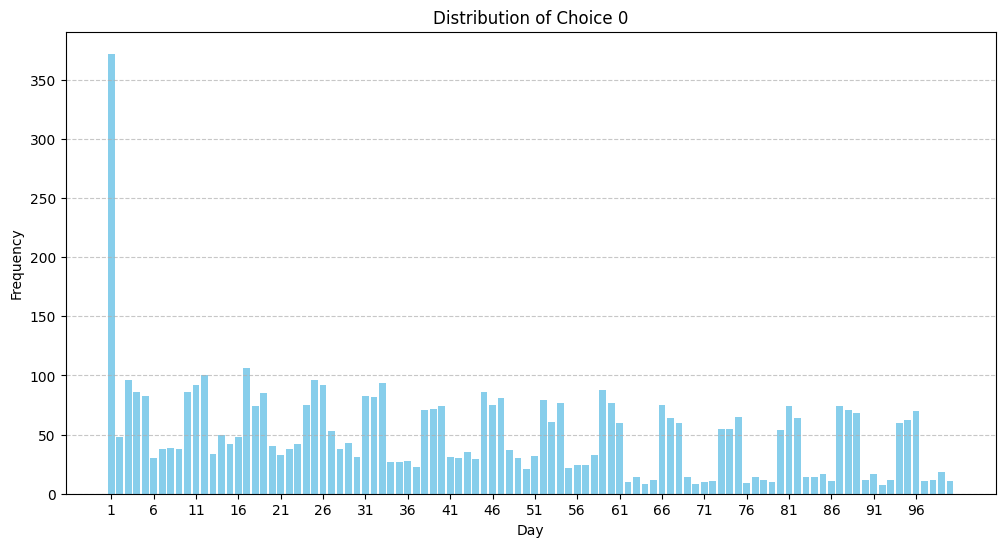

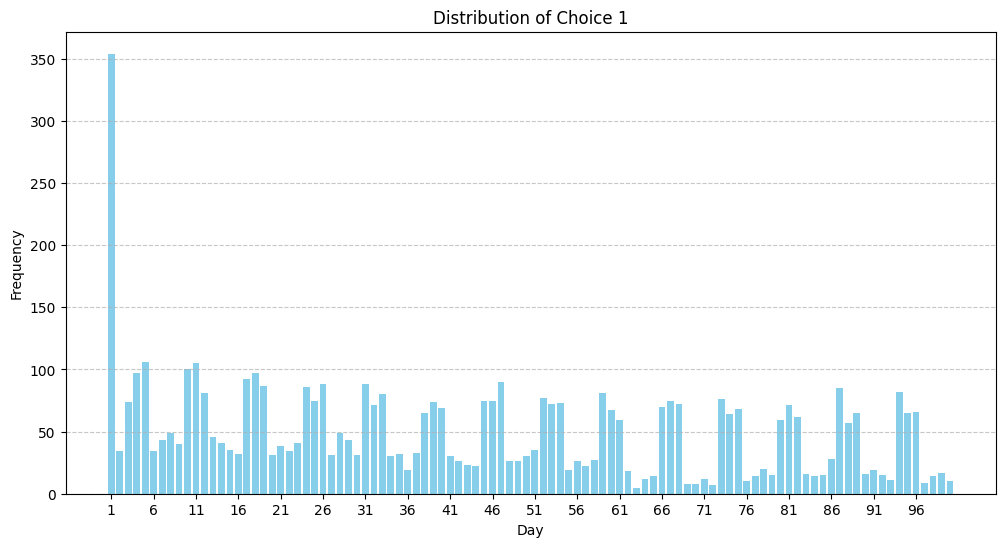

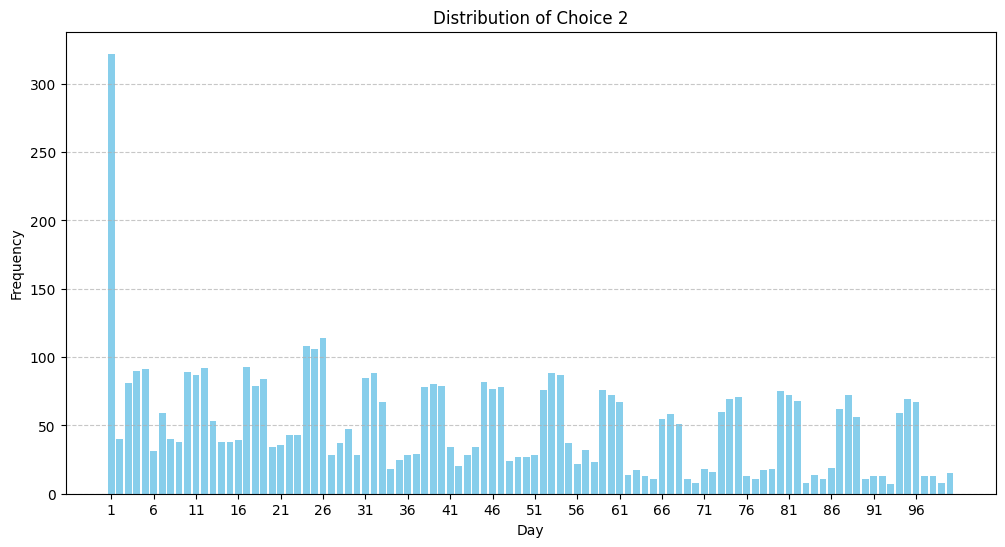

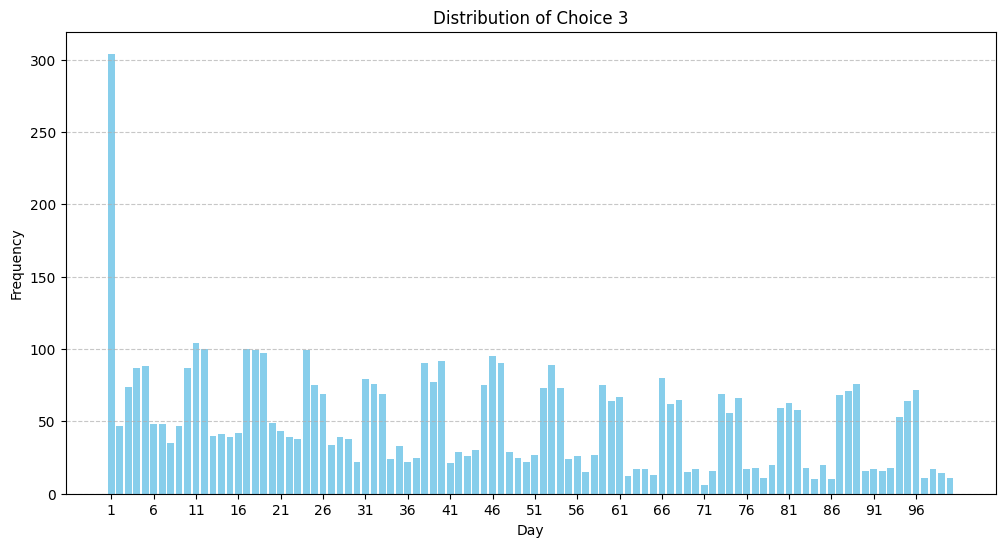

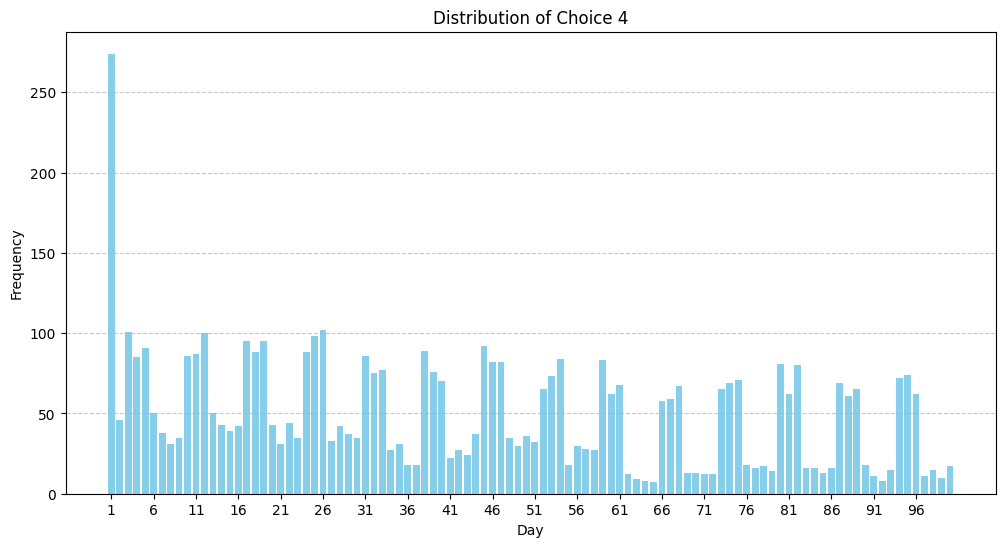

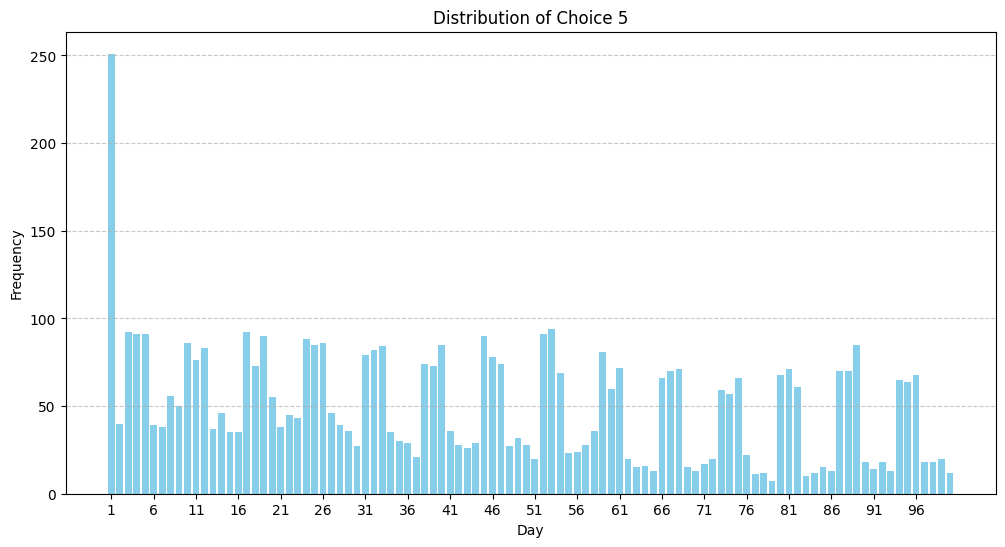

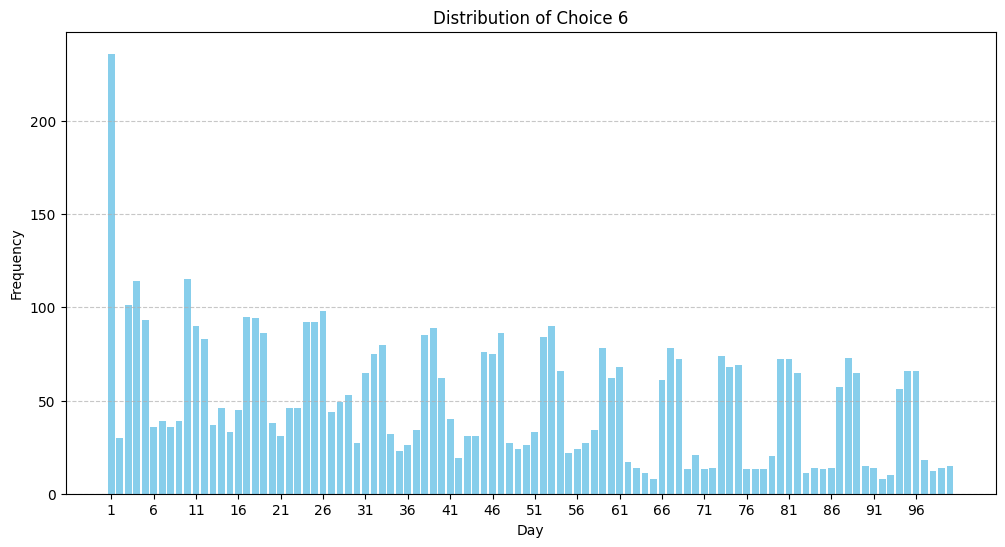

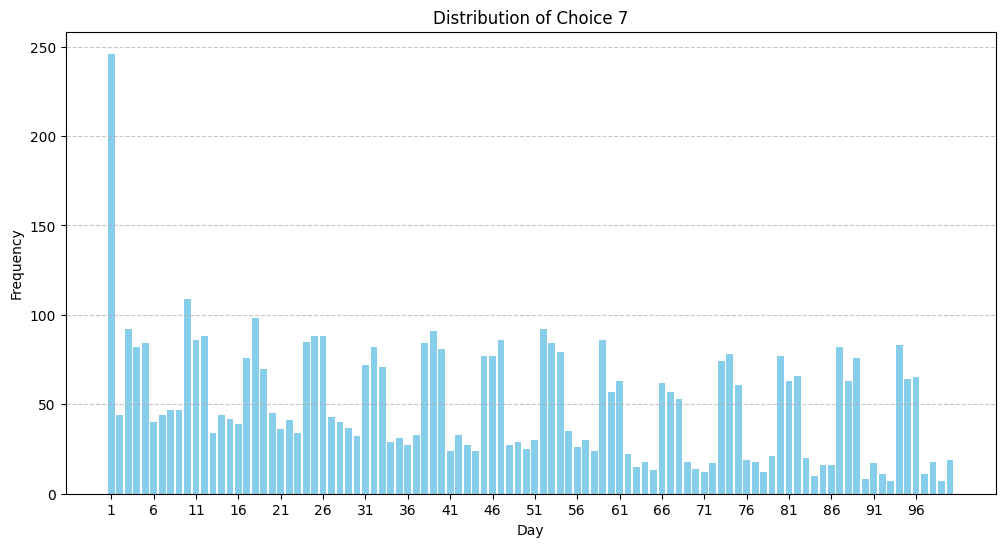

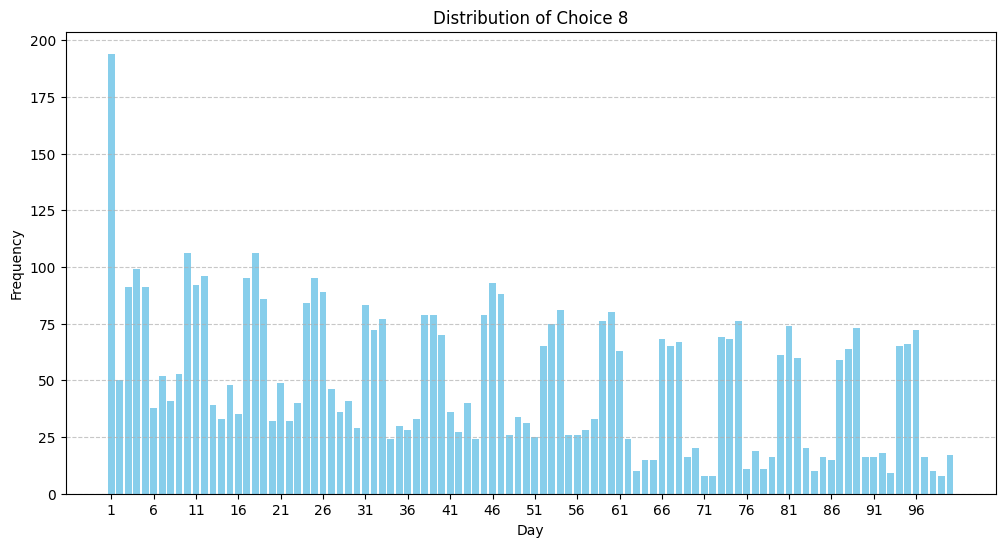

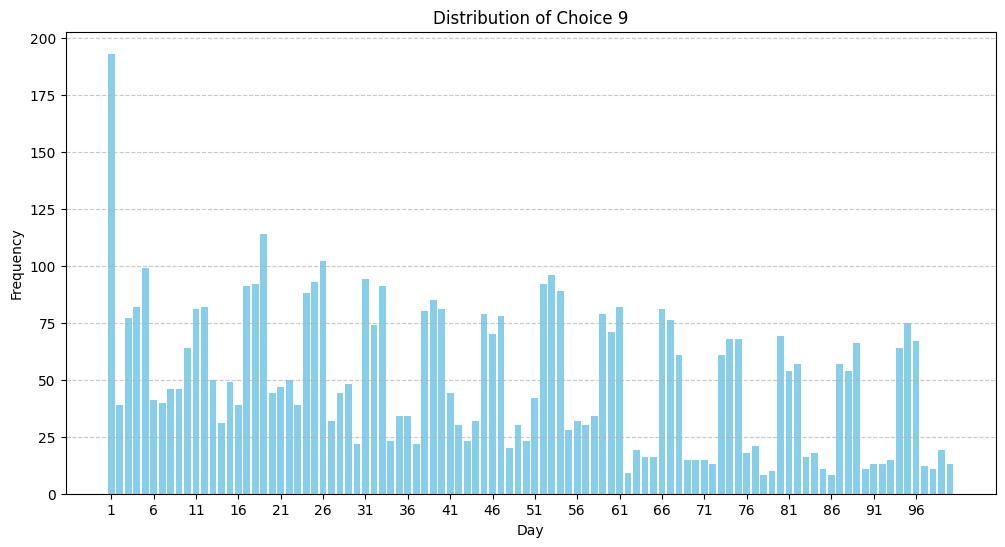

In [23]:
# Plot the distribution of days in choices

for choice in range(10):
    # Extract the specific choice from the DataFrame
    choice_data = data[f'choice_{choice}']

    # Flatten the choice into a single array
    all_choices = choice_data.values

    # Count occurrences of each day
    days, counts = np.unique(all_choices, return_counts=True)

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    plt.bar(days, counts, color='skyblue')
    plt.title(f'Distribution of Choice {choice}')
    plt.xlabel('Day')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(1, 101, step=5))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

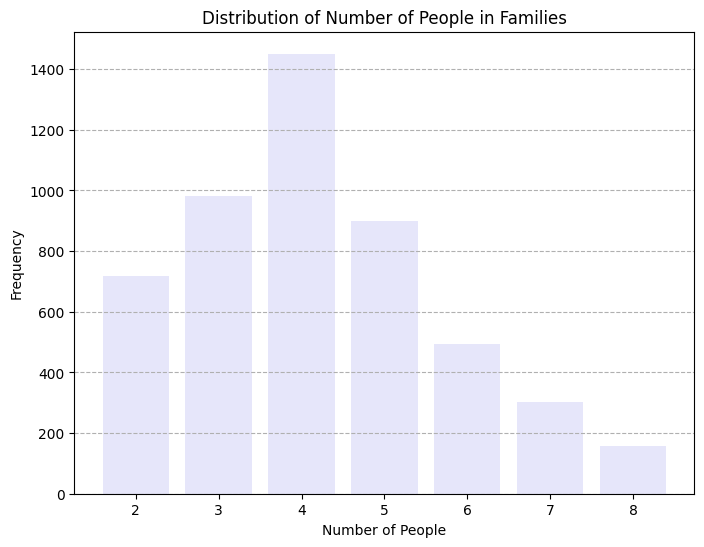

In [29]:
# Calculate the frequency of each number of people in families
people_counts = data['n_people'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(people_counts.index, people_counts.values, color='lavender')
plt.title('Distribution of Number of People in Families')
plt.xlabel('Number of People')
plt.ylabel('Frequency')
plt.xticks(people_counts.index)
plt.grid(axis='y', linestyle='--')
plt.show()

### Penalty cost for Santa

> The total number of people attending the workshop each day must be between $125$ - $300$; if even one day is outside these occupancy constraints, the submission will error and will not be scored.

> Santa provides consolation gifts to families. These sum up per family, and the total represents the **$preference:cost$**:
- `choice_0`: no consolation gifts
- `choice_1`: \$50
- `choice_2`: \\$50, \$9 for each family member
- `choice_3`: \\$100, \$9 for each family member
- `choice_4`: \\$200, \$9 for each family member
- `choice_5`: \\$200, \$18 for each family member
- `choice_6`: \\$300, \$18 for each family member
- `choice_7`: \\$300, \$36 for each family member
- `choice_8`: \\$400, \$36 for each family member
- `choice_9`: \\$500, \\$36 for each family member, \\$199 for each family member
- `otherwise`: \\$500, \\$36 for each family member, \$398 for each family member.

> $$accoutning:penalty = \sum_{d=100}^1\frac{N_d-125}{400}N_d^{\frac{1}{2}+\frac{|N_d-N_{d+1}|}{50}}$$
> where $N_d$ is the occupancy of the current day, and $N_{d+1}$ is the occupancy of the previous day (since we're counting backwards from Christmas! For the initial condition of $d=100$, $N_{101}=N_{100}$.

> **Finally $score=preference:cost+accounting:penalty$**

### Genetic Algorithm Implementation

In [3]:
class GeneticScheduler:
    def __init__(self,
                 file_location,
                 population_size=50,
                 mutation_rate=0.1,
                 num_generations=10000,
                 family_num=5000,
                 number_of_days=100,
                 min_constraint=125,
                 max_constraint=300,
                 number_of_preferences=10,
                 unchanged_generations_limit=100):
        self.num_days = number_of_days
        self.family_num = family_num
        self.MIN_PEOPLE = min_constraint
        self.MAX_PEOPLE = max_constraint
        self.preferences_num = number_of_preferences

        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.num_generations = num_generations

        # Read DataFrame with family preferences
        family_data = pd.read_csv(file_location)
        # Column names for preferences in DF
        pref_columns = [f'choice_{i}' for i in range(10)]

        # Numpy matrix (5000, 10) with each 10 preferences for each family
        self.family_pref_matrix = family_data[pref_columns].to_numpy()

        # Numpy array of family sizes, where index is family_id
        self.family_sizes = family_data['n_people'].to_numpy()

        # Sizes of the families in DF
        unique_family_sizes = np.sort(np.unique(self.family_sizes))

        # Price Santa pays for each family according to assigned day
        self.consolation_gifts = {
            n: np.array([
                0,
                50,
                50 + 9 * n,
                100 + 9 * n,
                200 + 9 * n,
                200 + 18 * n,
                300 + 18 * n,
                300 + 36 * n,
                400 + 36 * n,
                500 + 36 * n + 199 * n,
                500 + 36 * n + 398 * n
            ])
            for n in unique_family_sizes
        }

        self.population = self.generate_initial_population()
        self.unchanged_generations_limit = unchanged_generations_limit
        self.best_solution = None
        self.best_fitness = float('inf')
        self.unchanged_generations_count = 0

    def fitness_function(self, chromosome):
        # 212.5

        # List of indexes corresponding to the days that the families are scheduled to visit based on the chromosome.
        assigned_days = [(i+1)-(i//self.num_days)*self.num_days for i in range(0, self.num_days*self.family_num) if chromosome[i] == 1]

        fitness = 0

        # To count number of people scheduled at each day
        day_workshops_number = {d:0 for d in range(self.num_days, 0, -1)}

        # Looping over each family;
        # fam_size - number of people in that family
        # day - chosed day for that family in given chromosome
        # preferecnes - numpy array of 10 preferences of that family
        for fam_size, day, preferences in zip(self.family_sizes, assigned_days, self.family_pref_matrix):

            # add the family member count to the daily occupancy`
            day_workshops_number[day] += fam_size

            if day not in preferences:
                # Calculate the penalty for getting any preferences
                fitness += self.consolation_gifts[fam_size][-1]
            else:
                # Calculate the penalty for not getting 1st preeference of that family
                index = np.where(preferences == day)[0][0]  # Get the index of the chosen day in preferences
                fitness += self.consolation_gifts[fam_size][index]

        for n in day_workshops_number.values():
            if (n < self.MIN_PEOPLE) or (n > self.MAX_PEOPLE):
                # soft constraints for better convergency for the fitness to mininum
                fitness += 10**9

        accounting_penalty = max(0, (day_workshops_number[100] - 125.0) / 400.0 * day_workshops_number[100]**0.5)
        yesterday_workshops_number = day_workshops_number[100]
        for day in range(99, 0, -1):
            today = day_workshops_number[day]
            diff = abs(today - yesterday_workshops_number)
            accounting_penalty += max(0, (today-125.0) / 400.0 * today**(0.5 + diff / 50.0))
            yesterday_workshops_number = today

        fitness += accounting_penalty
        return fitness

    def generate_initial_population(self):
        # initialize population with population_size chromosomes
        # chromosome - binary vector of size 500000 (5000 families and 100 days for each)

        """
        Each element in this vector corresponds to a particular family on a specific day.
        If the value is 1, it means that the corresponding family is scheduled to visit on
        that particular day, and if it's 0, it means the family is not scheduled to visit
        on that day.
        """

        population = []
        for _ in range(self.population_size):
            chromosome = np.zeros(self.num_days*self.family_num, dtype=int)
            days_capacity = {d: 0 for d in range(0, self.num_days)}

            families_order = list(range(self.family_num))
            random.shuffle(families_order)

            for i in families_order:
                flag = True
                for j in range(self.preferences_num):
                    day_candidate = self.family_pref_matrix[i][j]
                    day_load = days_capacity[day_candidate - 1]
                    if day_load + self.family_sizes[i] < (self.MIN_PEOPLE + self.MAX_PEOPLE)/2:
                    # if day_load < self.MAX_PEOPLE - 10:
                        chromosome[i*self.num_days + day_candidate - 1] = 1
                        days_capacity[day_candidate - 1] += self.family_sizes[i]
                        flag = False
                        break
                if flag:
                    chromosome[i*self.num_days + np.random.randint(self.num_days)] = 1

            population.append(chromosome)

        return population

    def mutation(self, chromosome):
      num_mutations = random.randint(0, 50)

      for _ in range(num_mutations):
          line_index = random.randint(0, 4999)
          start_index = line_index * self.num_days
          end_index = start_index + self.num_days

          chromosome[start_index:end_index] = [0] * self.num_days
          chromosome[start_index:end_index][random.randint(0, self.num_days-1)] = 1

      return chromosome

    def crossover(self, parent1, parent2):
        # Randomly choose the number of crossover points (1 to 10)
        num_crossover_points = random.randint(1, 3)
        crossover_points = sorted(random.sample(range(1, 4999), num_crossover_points))
        crossover_points.insert(0, 0)
        crossover_points.append(5000)

        child1 = []
        child2 = []
        for i in range(len(crossover_points) - 1):
            # Choose parent for the segment
            if i % 2 == 0:
                segment1 = parent1[crossover_points[i] * 100: crossover_points[i + 1] * 100]
                segment2 = parent2[crossover_points[i] * 100: crossover_points[i + 1] * 100]
            else:
                segment1 = parent2[crossover_points[i] * 100: crossover_points[i + 1] * 100]
                segment2 = parent1[crossover_points[i] * 100: crossover_points[i + 1] * 100]

            child1.extend(segment1)
            child2.extend(segment2)

        return child1, child2

    def select_parents(self, population, scores, parents_size):
        selected_parents = []
        for _ in range(parents_size):
            idx1, idx2 = np.random.choice(range(len(population)), size=2, replace=False)
            if scores[idx1] < scores[idx2]:
                selected_parents.append(population[idx1])
            else:
                selected_parents.append(population[idx2])
        return selected_parents

    def replace(self, offsprings, population_scores):
      population_with_scores = [(self.population[i], population_scores[i]) for i in range(self.population_size)]
      offsprings_with_scores = [(offsprings[i], self.fitness_function(offsprings[i])) for i in range(len(offsprings))]
      new_population = [chromosome for chromosome, score in sorted(population_with_scores+offsprings_with_scores, key=lambda x: x[1])]
      new_population = new_population[:self.population_size]
      return new_population

    def run(self):
        for generation in range(self.num_generations):
            # Evaluate the fitness of each chromosome in the population
            population_scores = [self.fitness_function(chromosome) for chromosome in self.population]

            # Remember the best solution
            best_fitness = min(population_scores)
            if best_fitness < self.best_fitness:
                self.best_solution = self.population[population_scores.index(best_fitness)]
                self.best_fitness = best_fitness
                self.unchanged_generations_count = 0
            else:
                self.unchanged_generations_count += 1

            # Check if fitness not updated for generations / 10
            if self.unchanged_generations_count > self.unchanged_generations_limit or (self.unchanged_generations_count > 10 and self.best_fitness > 10**6):
                # Regenerate initial population
                self.population = self.generate_initial_population()
                self.unchanged_generations_count = 0
                print("Regenerated initial population.")

            # Select parents for crossover
            parents = self.select_parents(self.population, population_scores, self.population_size // 2)

            # Perform crossover to create offsprings
            offsprings = []
            for i in range(len(parents) - 1):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                offsprings.append(child1)
                offsprings.append(child2)

            # Apply mutation to the offspring
            for i in range(len(offsprings)):
                offsprings[i] = self.mutation(offsprings[i])

            # Replace the old population with the new one (including offspring)
            self.population = self.replace(offsprings, population_scores)

            # Placeholder printing for demonstration
            current_best_fitness = min(population_scores)
            print(f"Generation {generation + 1}: Best fitness = {self.best_fitness} Best fitness in current population = {current_best_fitness}")


file_location = 'family_data.csv'
scheduler = GeneticScheduler(file_location)
scheduler.run()

KeyboardInterrupt: 

In [ ]:
# Save best solution to a file
with open('best_solution.txt', 'w') as file:
    file.write(str(scheduler.best_solution))

# Print best solution
print("Best solution:", scheduler.best_solution)


NameError: name 'scheduler' is not defined